# Demonstration of dato

In [1]:
import sys
sys.path.insert(0, '/Users/robertyi/repos/dataframe/dato')
from dato import *
from dato.sampledata.datagen import user_data, purchase_data
import dato
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd

## Create some synthetic data
Let's start by making some synthetic data. Below I use some boilerplate numpy + pandas code to generate some weekly fluctuating revenue data.

In [2]:
users = user_data(1000, random_state=2701)
purchases = purchase_data(1000)

## Overview of data
We have two tables:

* `users`
* `purchases`

These should roughly mirror the kind of information companies will typically log (if star schema is being used) -- dimension tables describing *states*, such as a user information table; fact tables describing *events*, such as a purchases or visits table.

We'll assume we've loaded these as `pd.DataFrame`s from your data lake. Let's see how we would traditionally parse these.

## Plotting

Even for basic plotting of time trends, this can be quite cumbersome. Tools like superset and tableau make this significantly easier, but for data scientists who like to stay within the python ecosystem, substantial cleaning will nonetheless be required.

### Histograms

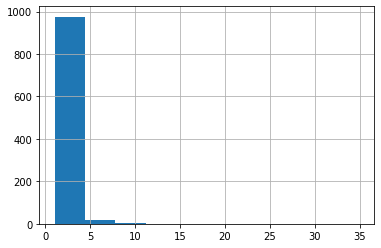

In [3]:
purchases.sale_value.hist()

Histograms are quite easy to plot, but typically some sort of log-scaling is necessary, especially for long-tailed distributions.

Iterations are usually required.

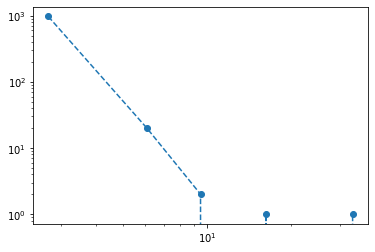

In [4]:
y, x = np.histogram(purchases.sale_value)
plt.plot((x[1:] + x[:-1])/2, y, 'o--')
plt.xscale('log')
plt.yscale('log')

`dato` makes this just as easy, but with a few small QOL improvements:

* Declarative syntax.
* Automatic ipython-suitable styling.
* Better defaults.

Moreover, the functions wrap matplotlib/pandas/numpy, so any arguments that apply to the base functions can be passed.

In [5]:
# We support dark mode (not on by default).
# Enabling it here because we like it.
import dato

# To set the theme globally, use:
# dato.style.use('dato_dark') # or 'dato_light'.
# For now, we set the theme just for dato plots.
dato.style.use('dato_dark', dato_only=True)

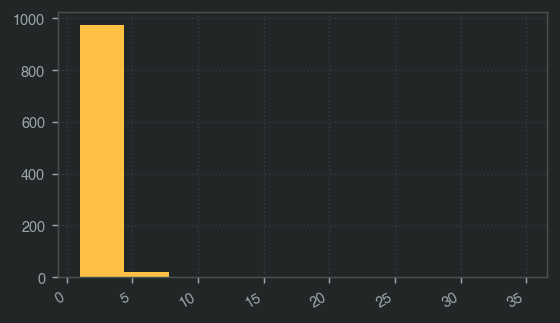

In [6]:
a = purchases.sale_value >> Hist

(array([976.,  20.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.00799888,  4.39817982,  7.78836075, 11.17854169, 14.56872263,
        17.95890357, 21.3490845 , 24.73926544, 28.12944638, 31.51962732,
        34.90980825]),
 <a list of 10 Patch objects>)

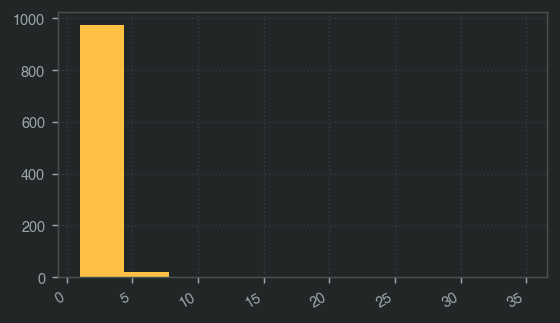

In [7]:
purchases >> Hist('sale_value')

## Scatter plots

In [8]:
a, b, c = np.array_split(users, 3)

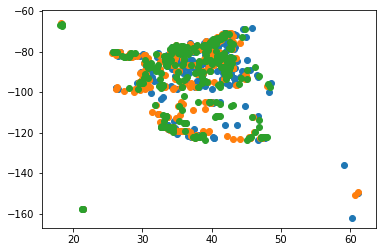

In [9]:
plt.scatter(a.lat, a.lng)
plt.scatter(b.lat, b.lng)
plt.scatter(c.lat, c.lng)

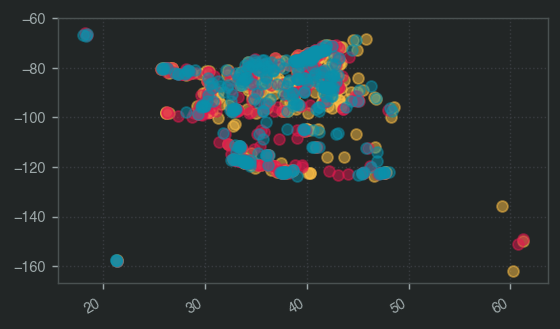

In [10]:
(a.lat, a.lng) >> Plot(kind='scatter')
(b.lat, b.lng) >> Plot(kind='scatter')
(c.lat, c.lng) >> Plot(kind='scatter')

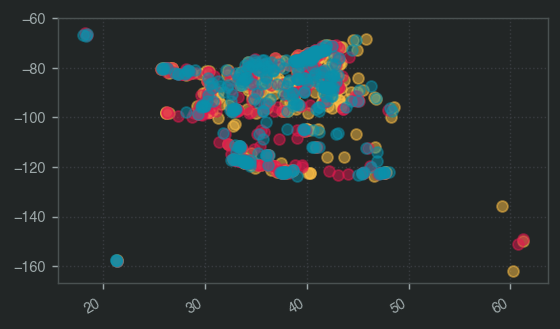

In [11]:
(a.lat, a.lng) >> Scatter
(b.lat, b.lng) >> Scatter
(c.lat, c.lng) >> Scatter

In [12]:
df = users.head(10)

## Seaborn-style/pandas-style plotting

In [13]:
a = users >> TopBy('state_name', N=3)

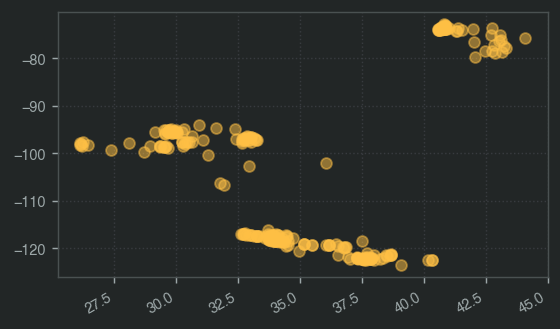

In [14]:
a >> Scatter(x='lat', y='lng')

In [15]:
a = a >> TopBy('county_name', 10)

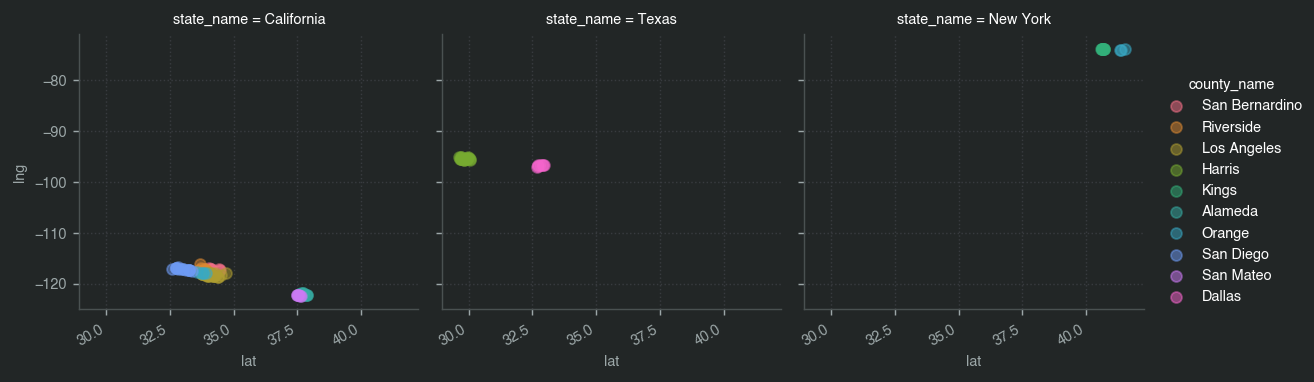

In [16]:
a >> Plot(kind='scatter', x='lat', y='lng', col='state_name', hue='county_name')

## Aggregations

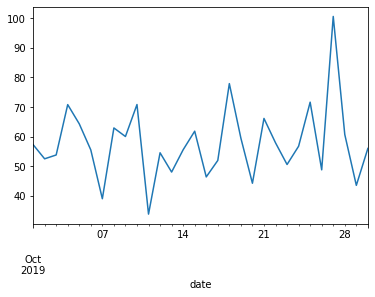

In [17]:
purchases_copy = purchases.copy()
purchases_copy['date'] = pd.to_datetime(purchases_copy.date)
gb = purchases_copy.groupby('date').sum()['sale_value']
gb.plot()

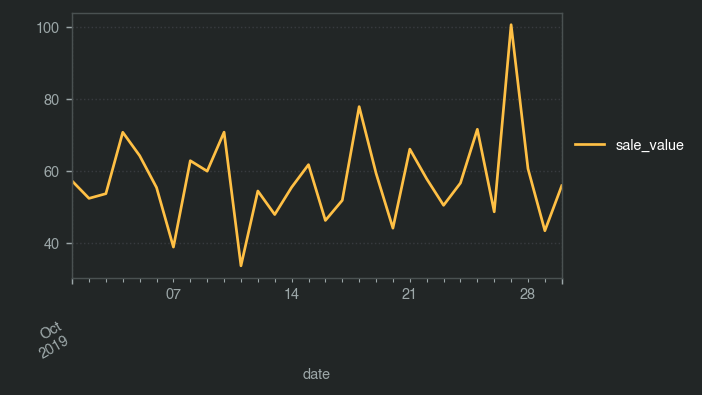

In [18]:
a = purchases >> ToDatetime('date') >> GroupBy('date') >> Sum('sale_value') >> Plot

## Light mode

In [19]:
import dato
dato.use('dato_light', dato_only=True)

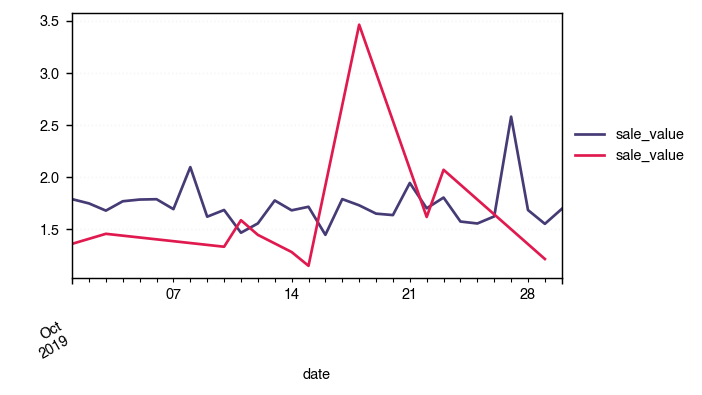

In [20]:
purchases \
    >> ToDatetime('date') \
    >> GroupBy('date') \
    >> Mean('sale_value') \
    >> Plot

purchases \
    >> Sample(20, replace=True, random_state=2701) \
    >> GroupBy('date') \
    >> Mean('sale_value') \
    >> Plot

## Making new Pipeable objects

To reduce code, it's easy to take these pipelines and make new Pipeable objects. For example, we can take the above bit of code and rewrite it with pipeable functions as follows.

In [21]:
# With a lambda
DoAll = Pipeable(lambda x: x >> ToDatetime('date') >> GroupBy('date') >> Mean('sale_value') >> Plot) 

# With a function
@Pipeable
def DoAll(df):
    plot_output = df >> ToDatetime('date') >> GroupBy('date') >> Mean('sale_value') >> Plot
    return plot_output

This can then be used to write significantly shortened, efficient, functional code that is still quite readable.

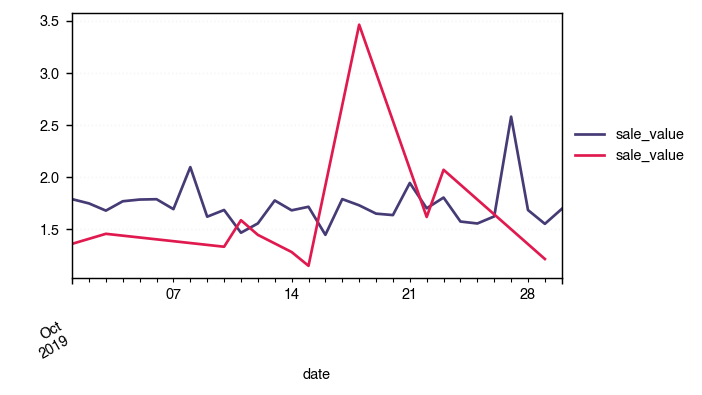

In [22]:
purchases >> DoAll

purchases >> Sample(20, replace=True, random_state=2701) >> DoAll

## ML

In [23]:
modelspec = (users, purchases) \
    >> Merge(on='id_user') \
    >> Select('population', 'density', 'sale_value', 'city') \
    >> InitModel(label='sale_value') \
    >> LabelEnc(columns=['city']) \
    >> TrainTestSplit(random_state=2701)

## Classifier

AUC: 
1.0


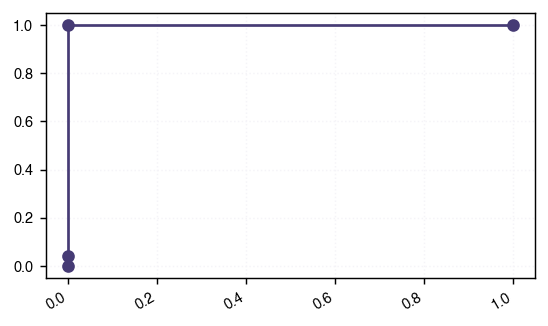

In [24]:
df = purchases.copy()
# Create a mock "sales" column.
df['sales'] = (df['sale_value'] > 1.5).astype(int)

modelspec = df \
    >> Select('sale_value', 'sales') \
    >> InitModel(label='sales') \
    >> TrainTestSplit(random_state=2701) \
    >> LogisticReg()